In [113]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import math
from utils import *
import plotly.graph_objects as go

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import euclidean
from voronoi_mod import *

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
match_id = 1133199
file_path = f'data/FA/tracking/{match_id}.jsonl'
data = load_jsonl_file(file_path)

file_path = f'data/FA/match/{match_id}.json'
match_data = load_json_file(file_path)
home_id = match_data['home_team']['id']
away_id = match_data['away_team']['id']

home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]

In [25]:
frame = 2626
recipient_id = 68683

In [9]:
frame_data = [f for f in data if f['frame'] == frame]

In [11]:
frame_df = pd.DataFrame(frame_data)

In [14]:
expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)

In [28]:
expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')

In [29]:
recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()
recipient_team

'away'

In [44]:
pitch_length, pitch_width = find_pitch_size(match_id)

In [27]:
expanded_df

,x,y,player_id,is_detected,object,z,frame,timestamp,period,possession,image_corners_projection,team
0,-29.53,2.17,52925,False,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
1,-1.68,-6.99,64113,False,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
2,-1.99,9.77,68737,False,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
3,24.44,-14.22,64167,False,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
4,12.13,28.13,68736,True,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
5,9.45,-2.91,63782,True,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
6,7.55,12.09,63774,True,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
7,30.96,-13.80,62787,False,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
8,19.63,-8.21,57095,False,player,NaN,2626,00:04:12.60,1,NaN,NaN,away
9,23.65,28.73,68683,True,player,NaN,2626,00:04:12.60,1,NaN,NaN,away


In [40]:
recipient_df = expanded_df[expanded_df['player_id'] == recipient_id]
recipient_xy = recipient_df[['x', 'y']].to_numpy()[0]
defending_df = expanded_df[expanded_df['team'] != recipient_team]
defending_xy = defending_df[['x', 'y']].to_numpy()

In [42]:
factor_x = 1 if recipient_xy[0] > 0 else -1
factor_y = 1 if recipient_xy[1] > 0 else -1

In [53]:
boundary_points = np.array(
    [[recipient_xy[0], pitch_width/2*factor_y+(pitch_width/2*factor_y-recipient_xy[1])], 
     [recipient_xy[0], recipient_xy[1] - 15*factor_y],
     [pitch_length/2*factor_x+(pitch_length/2*factor_x-recipient_xy[1]), recipient_xy[1]],
     [recipient_xy[0] - 15, recipient_xy[1]], 
     [recipient_xy[0] + 15, recipient_xy[1]]]) 

In [56]:
points = np.vstack([recipient_xy, defending_xy, boundary_points])

In [62]:
points_nbs = get_neighbors(points, recipient_xy)
vertices = get_vertices(points_nbs, recipient_xy)

In [69]:
area_left, area_right, vertices_left, vertices_right = get_areas(vertices, recipient_xy) 
log_area_left = np.log(area_left+1)
SoF = log_area_left + area_right

In [72]:
hull_points = np.array([p for i, p in enumerate(points_nbs) if 
              not np.any((p == boundary_points).all(axis = 1))])

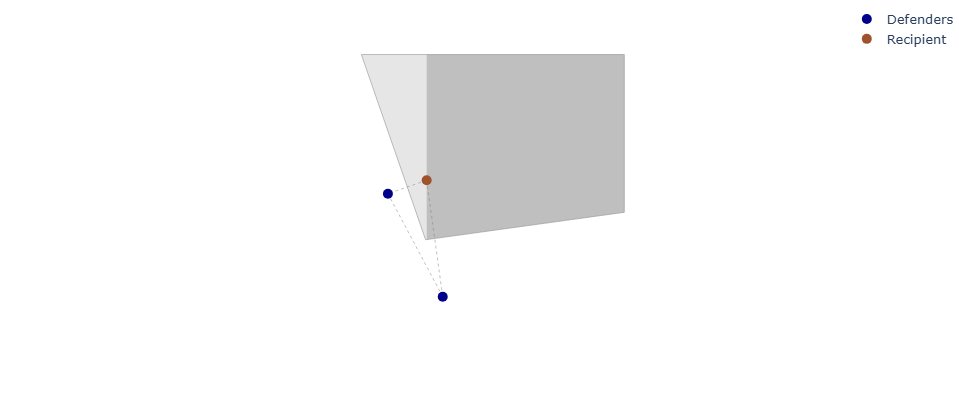

In [92]:
fig = plot_vor(points_nbs, hull_points, recipient_xy, boundary_points, vertices, 
         vertices_left, vertices_right)
fig.show()

In [127]:
filtered_df = pd.read_csv('data/filtered_df.csv')
filtered_df.head(1)

,sk_match_id,frame,minute,player_name,pass_recipient_name,pass_recipient_id,pass_recipient_position,sk_player_id,pass_angle,type_primary,type_secondary,location_x,location_y,pass_accurate,team_name,possession_team_name,possession_team_name_src,possession_types,period,receive_frame,receive_x,receive_y,target_area,ball_x_0,ball_y_0,ball_x_1,ball_y_1,player_1,ball_x_2,ball_y_2,player_2,ball_x_3,ball_y_3,player_3,player_0,sk_recipient_id,long_name,dist_0,dist_1,dist_2,dist_3,score_1,score_2,score_3
0,1133199,558,0,D. Spence,C. Bizet Ildhusøy,501647,RCMF3,57095.0,56,pass,['lateral_pass' 'short_or_medium_pass'],70,65,True,Tottenham Hotspur,Tottenham Hotspur,Tottenham Hotspur,['attack' 'transition_low'],1.0,567.0,26.96,-22.12,True,27.25,-20.27,47.2,-12.22,62787.0,50.47,-10.74,57093.0,NaN,NaN,NaN,NaN,62787,Celin Bizet Ildhusøy,31.605939,12.954474,10.789277,10.789277,2.0,2.0,2.0


In [108]:
filtered_df.shape

(12022, 44)

In [111]:
for idx, row in filtered_df.iterrows():
    match_id = row['sk_match_id']
    recipient_id = row['sk_recipient_id']
        
    frame = row['receive_frame']

    file_path = f'data/FA/tracking/{match_id}.jsonl'
    frame_data = load_jsonl_file_frame(frame)
    file_path = f'data/FA/match/{match_id}.json'
    match_data = load_json_file(file_path)    

    home_id = match_data['home_team']['id']
    away_id = match_data['away_team']['id']
    
    home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
    away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]

    frame_df = pd.DataFrame(frame_data)

    expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
    expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')
    recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()

    pitch_length, pitch_width = match_data['pitch_length'], match_data['pitch_width']
    recipient_df = expanded_df[expanded_df['player_id'] == recipient_id]
    recipient_xy = recipient_df[['x', 'y']].to_numpy()[0]
    defending_df = expanded_df[~expanded_df['team'].isin([recipient_team, 'ball'])]
    defending_xy = defending_df[['x', 'y']].to_numpy()

    factor_x = 1 if recipient_xy[0] > 0 else -1
    factor_y = 1 if recipient_xy[1] > 0 else -1    

    boundary_points = np.array(
        [[recipient_xy[0], pitch_width/2*factor_y+(pitch_width/2*factor_y-recipient_xy[1])], 
         [recipient_xy[0], recipient_xy[1] - 20*factor_y],
         [pitch_length/2*factor_x+(pitch_length/2*factor_x-recipient_xy[1]), recipient_xy[1]],
         [recipient_xy[0] - 20, recipient_xy[1]], 
         [recipient_xy[0] + 20, recipient_xy[1]]])     

    points = np.vstack([recipient_xy, defending_xy, boundary_points])
    points_nbs = get_neighbors(points, recipient_xy)
    vertices = get_vertices(points_nbs, recipient_xy)
    area_left, area_right, vertices_left, vertices_right = get_areas(vertices, recipient_xy) 
    log_area_left = np.log(area_left+1)
    SoF = log_area_left + area_right    

    filtered_df.at[idx, 'SoF'] = SoF
    # hull_points = np.array([p for i, p in enumerate(points_nbs) if 
    #               not np.any((p == boundary_points).all(axis = 1))])    

    # print(row['score_1'], row['score_2'], row['score_3'], SoF)
    # fig = plot_vor(points_nbs, hull_points, recipient_xy, boundary_points, vertices, 
    #          vertices_left, vertices_right)
    # fig.show()    

In [112]:
filtered_df.to_csv('data/SoF.csv', index = False)

In [133]:
filtered_df.head(1)

,sk_match_id,frame,minute,player_name,pass_recipient_name,pass_recipient_id,pass_recipient_position,sk_player_id,pass_angle,type_primary,type_secondary,location_x,location_y,pass_accurate,team_name,possession_team_name,possession_team_name_src,possession_types,period,receive_frame,receive_x,receive_y,target_area,ball_x_0,ball_y_0,ball_x_1,ball_y_1,player_1,ball_x_2,ball_y_2,player_2,ball_x_3,ball_y_3,player_3,player_0,sk_recipient_id,long_name,dist_0,dist_1,dist_2,dist_3,score_1,score_2,score_3
0,1133199,558,0,D. Spence,C. Bizet Ildhusøy,501647,RCMF3,57095.0,56,pass,['lateral_pass' 'short_or_medium_pass'],70,65,True,Tottenham Hotspur,Tottenham Hotspur,Tottenham Hotspur,['attack' 'transition_low'],1.0,567.0,26.96,-22.12,True,27.25,-20.27,47.2,-12.22,62787.0,50.47,-10.74,57093.0,NaN,NaN,NaN,NaN,62787,Celin Bizet Ildhusøy,31.605939,12.954474,10.789277,10.789277,2.0,2.0,2.0


In [143]:
match_dict = filtered_df.groupby('sk_match_id')['receive_frame'].apply(list).to_dict()

In [172]:
%%time
defender_count = []
attacker_count = []
key = None
for idx, row in filtered_df.iterrows():    
    match_id = row['sk_match_id']
    if key != match_id:
        key = match_id
        file_path = f'data/FA/tracking/{match_id}.jsonl'
        frame_list = match_dict[match_id]
        with jsonlines.open(file_path, 'r') as file:
            frames_data = [line for line in file if line['frame'] in frame_list]
        
    recipient_id = row['sk_recipient_id']       
    frame = row['receive_frame']
    file_path = f'data/FA/match/{match_id}.json'
    match_data = load_json_file(file_path)    
    pitch_length, pitch_width = match_data['pitch_length'], match_data['pitch_width']

    home_id = match_data['home_team']['id']
    away_id = match_data['away_team']['id']
    
    home_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == home_id]
    away_p_ids = [p['id'] for p in match_data['players'] if p['team_id'] == away_id]

    frames_df = pd.DataFrame(frames_data)
    frame_df = frames_df[frames_df['frame'] == frame]
    expanded_df = pd.concat(frame_df.apply(explode_data, axis=1).to_list(), ignore_index=True)
    expanded_df['team'] = expanded_df['player_id'].apply(lambda x: 'home' if x in home_p_ids else 'away' if x in away_p_ids else 'ball')
    recipient_team = expanded_df[expanded_df['player_id'] == recipient_id]['team'].item()

    recipient_x = expanded_df[expanded_df['player_id'] == recipient_id]['x'].item()
    factor_x = 1 if recipient_x > 0 else -1
    
    defender_deep_df = expanded_df[(~expanded_df['team'].isin([recipient_team, 'ball'])) & (
        expanded_df['x']*factor_x > (recipient_x *factor_x - 2))]
    defender_deep_count = len(defender_deep_df) - 1
    attacker_deep_df = expanded_df[(expanded_df['team'] == recipient_team) & (
        expanded_df['x']*factor_x > (recipient_x *factor_x - 2))]
    attacker_deep_count = len(attacker_deep_df) - 1
    
    defender_count.append(defender_deep_count)
    attacker_count.append(attacker_deep_count)    
    
print(len(defender_count), len(attacker_count))

filtered_df['defender_count'] = defender_count
filtered_df['attacker_count'] = attacker_count    

12022 12022
CPU times: total: 6min 46s
Wall time: 6min 47s


In [168]:
defender_count

[1, 4, 4, 7]

In [169]:
attacker_count

[0, 3, 2, 5]

In [173]:
filtered_df.to_csv('data/count.csv', index = False)

In [166]:
attacker_deep_df

,x,y,player_id,is_detected,object,z,frame,timestamp,period,possession,image_corners_projection,team
11,26.68,-2.40,22805,False,player,NaN,22062,00:36:36.20,1,NaN,NaN,home
15,-34.99,9.99,63556,True,player,NaN,22062,00:36:36.20,1,NaN,NaN,home
16,-26.65,-30.55,57099,True,player,NaN,22062,00:36:36.20,1,NaN,NaN,home
18,-27.08,-3.36,63800,True,player,NaN,22062,00:36:36.20,1,NaN,NaN,home
19,-26.58,-23.74,22364,True,player,NaN,22062,00:36:36.20,1,NaN,NaN,home
20,-31.91,-12.63,146967,True,player,NaN,22062,00:36:36.20,1,NaN,NaN,home
21,-33.48,-8.11,769835,True,player,NaN,22062,00:36:36.20,1,NaN,NaN,home


In [154]:
[p for p in match_data['players'] if p['id'] == 22805]

[{'player_role': {'id': 0,
   'position_group': 'Other',
   'name': 'Goalkeeper',
   'acronym': 'GK'},
  'start_time': '00:00:00',
  'end_time': None,
  'number': 1,
  'yellow_card': 0,
  'red_card': 0,
  'injured': False,
  'goal': 0,
  'own_goal': 0,
  'team_player_id': 82607,
  'team_id': 1834,
  'id': 22805,
  'first_name': 'Zecira',
  'last_name': 'Musovic',
  'short_name': 'Z. Musovic',
  'birthday': '1996-05-26',
  'trackable_object': 23560,
  'gender': 'female'}]

In [123]:
defender_deep_count

4